# Sample portfolio 1

This notebook runs through the library on the one of the examples in the __'sample_portfolio2'__

At the end we optimize to get the results of all the 8 different views

First we import everything

In [35]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

Then we get the data

In [36]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

We load the vies

In [37]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = 0);

We create the posterior distribution

In [38]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)



Results
Optimal dual variable values:  [ 1.14274328 -1.00061335]
Jacobian matrix at optimum [ 4.12050058e-07 -7.15674600e-06]


We get the deltas and create the asset space. Additionally, we import the additional constraints for the markoviz optimization.

We manually define to size of funds that can be used

In [39]:
total = 417000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

And finally we do markowitz optimization on the posterior distribution and plot the outcome.

We minimize the volatility at return $\mu_0 = 0.5$ and do not allow for shorting.

The optimization was succesful: True
Global Equities: -0.0
DM Equities: -0.0
EM Equities: 15202557.0
European Equities: -0.0
US Equities: 26497443.0
EUR Money Markets: 235026178.0
EUR Government Bonds: 83400000.0
EUR Covered Bonds: -0.0
EUR Investment Grade Corporate Bonds: 0.0
European High Yield Corporate Bonds: 41700000.0
EMD Hard Currency: -0.0
Hedge Funds: -0.0
Listed Private Equity: 15173822.0
Technical Provisions: 1.0
IR Hedges: 1.0


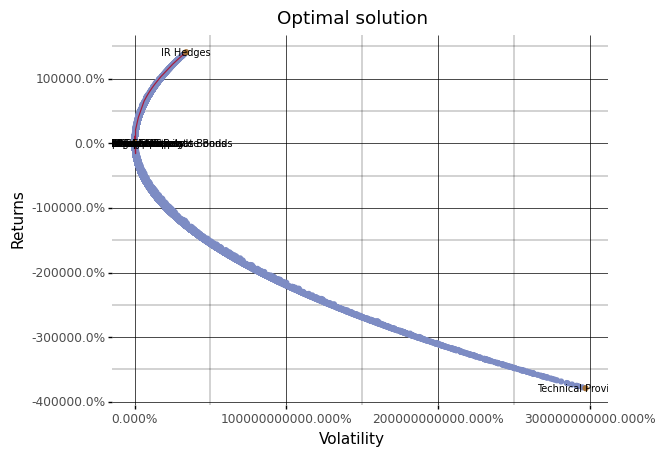

In [40]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 10000,
                                         total = total,
                                         manual_constraints = manual_constraints,
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

We can compare the optimization of the posterior distribution with the prior below

The optimization was succesful: True
Global Equities: -0.0
DM Equities: -0.0
EM Equities: -0.0
European Equities: 28677282.0
US Equities: -0.0
EUR Money Markets: 298124088.0
EUR Government Bonds: 83400000.0
EUR Covered Bonds: -0.0
EUR Investment Grade Corporate Bonds: -0.0
European High Yield Corporate Bonds: -0.0
EMD Hard Currency: -0.0
Hedge Funds: 6798630.0
Listed Private Equity: -0.0
Technical Provisions: 1.0
IR Hedges: 1.0


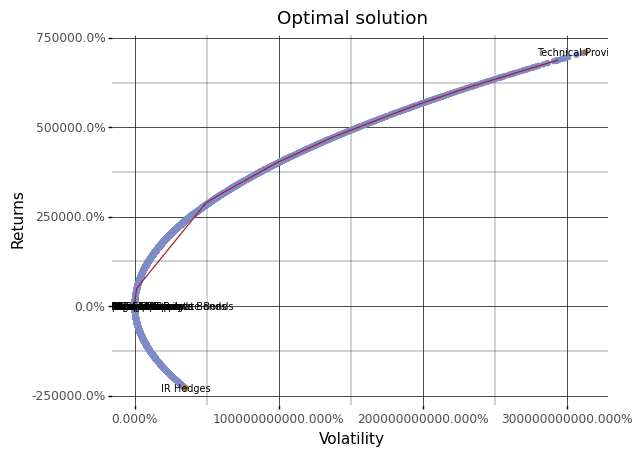

In [41]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weights,
                                         mu_0 = 10000,
                                         total = total,
                                         manual_constraints = manual_constraints,
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [42]:
result = pd.DataFrame(columns = range(8), index =['Result','Optimal risk', 'Expected return', *asset_names])
weights_pos = pd.DataFrame(columns = range(8))
for i in range(8):
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = i);
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  weights_pos.iloc[:,i] = weighted_posterior
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                           weighted_posterior,
                                           mu_0 = 20000,
                                           total = total,
                                           manual_constraints = manual_constraints,
                                           allow_shorting = True,
                                           visualize = False,
                                           verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  result.iloc[1,i] = optimal.fun / total**2
  result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
  result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
result
  

,0,1,2,3,4,5,6,7
Result,False,False,True,True,True,True,True,True
Optimal risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Return,-159.0,-2940.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
Global Equities,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
DM Equities,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
EM Equities,-0.0,-0.0,0.0,-0.0,-0.0,0.0,4032742.0,5258926.0
European Equities,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
US Equities,0.0,1.0,41700000.0,0.0,41700000.0,41700000.0,30963587.0,36441074.0
EUR Money Markets,-0.0,-0.0,199541738.0,151537362.0,130627716.0,218346843.0,-0.0,217279844.0
EUR Government Bonds,0.0,0.0,83400000.0,192556509.0,83400000.0,83400000.0,228583414.0,83400000.0
